## Rough Set based Approach

Notes: 
measures accuracy of clustering results using Variation of Information, Normalized Mutual Information, Rand Index, and adjusted Rand Index
for accuracy of classificationa and PageRank, use RMSE MAE and MSE
- the definitions in the paper do not align with the working example
- currently things are based on the implied defs from the working example, as that produced results more consistent with the paper in quick testing


In [35]:
import numpy as np
import networkx as nx
from itertools import combinations

In [4]:
import time

In [2]:
## we use the DD199 graph for testing
import pandas as pd
DD199 = nx.read_edgelist("Data/DD199/DD199.edges", nodetype=int)

## we also consider a 20 node BA graph
BAG = nx.barabasi_albert_graph(20,2)

In [3]:
BAG.neighbors(0)

In [3]:
def d_neighborhood(G, d):
    '''
    Returns a dictionary with as keys the nodes, and as values the d-neighborhood of that node as a set
    time complexity of this should be O(n*h^d) where h avg node degree, and d neighborhood size
    takes about 1 sec for d=3,4 h = 50, n = 1000, about 10 secs for n=10k d=2, h=100
    '''
    DDS = {}
    for v in G.nodes(): ## gets the d neighborhood of all nodes in G saves in a dict
        n0 = {v}
        totalset_v = set()
        for i in range(d):
            n1 = set()
            for node in n0:
                n1.update(G.neighbors(node))
            totalset_v.update(n0)
            n0 = n1 - totalset_v
        totalset_v.update(n0)
        DDS[v] = totalset_v
    return DDS

In [ ]:
'''
BAG = nx.barabasi_albert_graph(10000,100)
for i in range(1, 3):
    starttime = time.time()
    BAG_d_neigh = d_neighborhood(BAG, i)
    print(i, time.time()-starttime)
'''

In [108]:
def PPGP_v2(G:nx.Graph, delta = 0.2):
    '''
    Implements the PPGP method from https://doi.org/10.1016/j.eswa.2017.07.010
    method is as follows: connectedness subset is 2-neighborhood, 
    JS between nodes is computed using their neighbors,
    '''
    ##starttime = time.time()
    N1 = {vi: set(G.neighbors(vi)) for vi in G.nodes()}
    N2 = d_neighborhood(G,2) ## node: set of N2
    JS = {(vi,vj): len(N1[vi].intersection(N1[vj]))/len(N1[vi].union(N1[vj])) for (vi,vj) in combinations(list(G.nodes()),2)}
    
    JS_sorted = sorted(JS.items(), key = lambda it: it[1], reverse = True)

    ##print("N1,N2,JS: ",time.time()-starttime)
    E = []
    Ganon = nx.Graph()
    Ganon.add_nodes_from(G.nodes())

    ## for all JS > delta, if vi in N2 vj or vice versa, add to edge set
    for ((vi,vj), js) in JS_sorted:
        if js < delta:
            Ganon.add_edges_from(E)
            ##print("full alg: ",time.time()-starttime)
            return Ganon
        ## else:
        if vi in N2[vj]: ## need to check only one because N2 is symetrical
            E.append((vi,vj))
    

In [72]:
def PPGP(G:nx.Graph, delta = 0.5):
    '''
    Get the Neighborhood Connected Subset for each vertex, then the Connected Upper Approximation for each vertex
    compute the Jaccard similarity of each pair of vertices
    get constrained upper approx
    reconstruct graph
    NOTE: based on the examples with the def in text NOT the implied def from the working example (except for comp. of jaccard similarity)
    time complexity should be O(n*avg|Sbar|)
    '''
    starttime = time.time()
    two_neighborhood = d_neighborhood(G, 2)
    S = {vi: list(G.neighbors(vi))+[vi] for vi in G.nodes()}
    Sbar = {vi: [node for node in two_neighborhood[vi] if node not in S[vi]] for vi in G.nodes()}
    ## Sbar is 2neighbors -1neighbors
    
    ##JS = {(vi,vj): len(set(Sbar[vi]).intersection(Sbar[vj])) / len(set(Sbar[vi]).union(set(Sbar[vj]))) for (vi,vj) in combinations(list(G.nodes()),2)}
    ##JS.update({(vj,vi): value for (vi,vj),value in JS.items()})
    ##JS.update({(vi,vi): 1.0 for vi in G.nodes()})
    JS = {vi:{vj: len(set(G.neighbors(vi)).intersection(G.neighbors(vj))) / len(set(G.neighbors(vi)).union(G.neighbors(vj))) for vj in G.nodes()} for vi in G.nodes()}
    Shat = {}
    print(time.time()-starttime)
    ## maybe can be by computing only the intersection ofr the union
    ## in the kitegraph example of the text the jaccard similarity between two vertices is given by their neighbors

    ## this part is also a massive time sink
    for vi in G.nodes():
        myset_vi = set()
        for vl in Sbar[vi]:
            myset_vi.update([vj for vj in Sbar[vl] if JS[vi][vj] >= delta])
        Shat[vi] = myset_vi
    
    myedgelist = []
    for vi in G.nodes():
        for vj in Shat[vi]:
            if vi != vj:
                myedgelist.append((vi,vj))
    print(time.time()-starttime)
    
    anonG = nx.Graph()
    anonG.add_nodes_from(G.nodes())
    anonG.add_edges_from(myedgelist)
    print(time.time()-starttime)
    return anonG

In [91]:
##BAG = nx.barabasi_albert_graph(100,5)
## 7s for n=1k, avgDeg=h=2, 0.07s for n=100 h=2, 0.2s for n=100, h=20
## O(n^2)
##BAGanon = PPGP_v2(BAG)
## initialization is the time sink
## took 18s with fix, 37 without for 1k, h=20
## 0.03s n=100 h=2, 1.68s n=1000 h=2, 50s n=1k h=20 -> still O(n^2)
## v2: time sink is still the initialization still O(n^2) but faster now
## 1.2s n=1k h=20, 103s n=10k h=20 -> no edges added

N1,N2,JS:  0.030274152755737305
full alg:  0.03274393081665039


In [59]:
KiteGraph = nx.Graph()
KG_edges = [(1,2),(1,3),(1,4),(1,6),
            (2,4),(2,5),(2,7),
            (3,4),(3,6),
            (4,5),(4,6),(4,7),
            (5,7),
            (6,7),(6,8),
            (7,8),
            (8,9),
            (9,10)]
KiteGraph.add_edges_from(KG_edges)

In [72]:
##KG_anon = PPGP(KiteGraph, 0.25)

In [70]:
def PPGPworkingEx(G:nx.Graph, delta = 0.2):
    '''
    Returns the anonymized graph based on the implied definitions from the working example
    that is the KiteGraph example
    '''
    Sbar = d_neighborhood(G, 2)
    JS = {vi:{vj: len(set(G.neighbors(vi)).intersection(G.neighbors(vj))) / len(set(G.neighbors(vi)).union(G.neighbors(vj))) for vj in G.nodes()} for vi in G.nodes()}
    Shat = {}
    for vi in G.nodes():
        myset_vi = set()
        for vl in Sbar[vi]:
            myset_vi.update([vj for vj in Sbar[vl] if JS[vi][vj] >= delta])
        Shat[vi] = myset_vi

    anonG = nx.Graph()
    anonG.add_nodes_from(G.nodes())

    for vi in G.nodes():
        for vj in Shat[vi]:
            if vi != vj:
                anonG.add_edge(vi,vj)

    return anonG

## Check based on PageRank results what method is used in the paper

based on a fairly quick check with the Zachary dataset, the code based on the working example produces more sensible results
 - the error increased (fairly) consistently as delta increased.

In [73]:
## compute PageRank of the same network they used

## import Zachary Friendship network
from scipy.io import mmread
karate_data = mmread("../Data/soc-karate/soc-karate.mtx")
karate = nx.Graph(karate_data)

karate_workingEx = {}
for i in range(1,11):
    karate_workingEx[i] = PPGPworkingEx(karate, i*0.1)

karate_anon = {}
for i in range(1,11):
    karate_anon[i] = PPGP(karate, i*0.1)

0.0014362335205078125
0.0020842552185058594
0.002315044403076172
0.0013630390167236328
0.0019292831420898438
0.0021321773529052734
0.0013649463653564453
0.0018820762634277344
0.00197601318359375
0.0014750957489013672
0.0019910335540771484
0.002054929733276367
0.0013308525085449219
0.0017898082733154297
0.0018358230590820312
0.0013387203216552734
0.0017757415771484375
0.0018496513366699219
0.0013871192932128906
0.001811981201171875
0.0018510818481445312
0.0013430118560791016
0.0017828941345214844
0.001817941665649414
0.001390218734741211
0.0017809867858886719
0.0018019676208496094
0.0012650489807128906
0.001653909683227539
0.0016748905181884766


In [74]:
pr_karate = list(nx.pagerank(karate).values())

pr_k_workingEx = {}
pr_k_anon = {}
for i in range(1,11):
    pr_k_workingEx[i] = list(nx.pagerank(karate_workingEx[i]).values())
    pr_k_anon[i] = list(nx.pagerank(karate_anon[i]).values())

In [75]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error

In [76]:
RMSE_anon = []
RMSE_wEx = []
MAE_anon = []
MAE_wEx = []
MSE_anon = []
MSE_wEx = []
for i in range(1,11):
    RMSE_anon.append(root_mean_squared_error(pr_karate, pr_k_anon[i]))
    RMSE_wEx.append(root_mean_squared_error(pr_karate, pr_k_workingEx[i]))
    MAE_anon.append(mean_absolute_error(pr_karate, pr_k_anon[i]))
    MAE_wEx.append(mean_absolute_error(pr_karate, pr_k_workingEx[i]))
    MSE_anon.append(mean_squared_error(pr_karate, pr_k_anon[i]))
    MSE_wEx.append(mean_squared_error(pr_karate, pr_k_workingEx[i]))

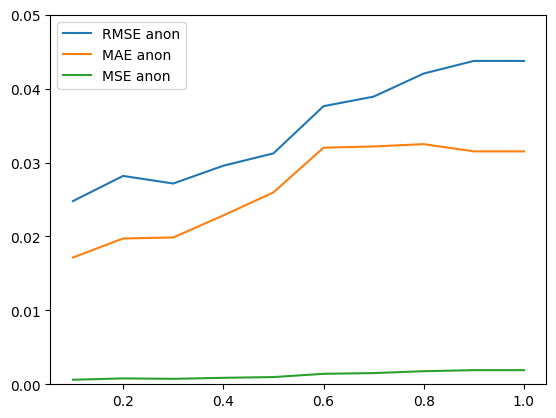

In [77]:
import matplotlib.pyplot as plt

x = list(range(1,11))
x = [a*0.1 for a in x]

# plot lines
plt.plot(x, RMSE_anon, label = "RMSE anon")
plt.plot(x, MAE_anon, label = "MAE anon")
plt.plot(x, MSE_anon, label = "MSE anon")
plt.ylim(0, 0.05)
plt.legend()
plt.show()

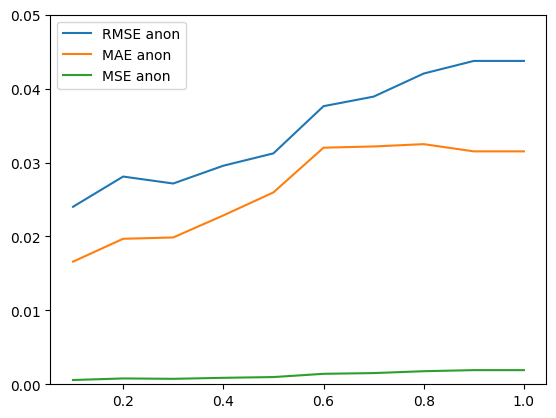

In [78]:
x = list(range(1,11))
x = [a*0.1 for a in x]

# plot lines
plt.plot(x, RMSE_wEx, label = "RMSE anon")
plt.plot(x, MAE_wEx, label = "MAE anon")
plt.plot(x, MSE_wEx, label = "MSE anon")
plt.ylim(0, 0.05)
plt.legend()
plt.show()